<h3 style="color:#3295ec;"><center>پروژه دوم درس شناسایی الگو - قسمت اول</center></h3>
<p style="text-align: right;">نام و نام خانوادگی :فرامرز نادری</p>
<p style="text-align: right;">97722203:شماره دانشجویی</p>

<img src="1.png " width=850 >

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
import math

df = pd.read_excel('2.xlsx'
                   , names=['Height', 'Lenght', 'Area', 'Eccen', 'P_black', 'P_and', 'Mean_tr', 'Blackpix', 'Blackand', 'Wb_trans','Class'])

In [2]:
def Smote(N,k,omcs):
    # Fit NearestNeighbors on Minority Data with k neighbors 
    nbrs = NearestNeighbors(n_neighbors=k).fit(omcs)
    np.random.seed(seed=0)
    Synthetic = np.zeros(shape=(N, 10))
    # Generate N synthetic sample for Minority Data
    for i in range(N):
        j = np.random.randint(0, omcs.shape[0])
        # Find k NearestNeighbors for omcs[j] of Minority Data
        nn = nbrs.kneighbors(omcs[j].reshape(1, -1),return_distance=False)[:, 1:]
        # Choice one of the NearestNeighbors for omcs[j] randomly
        nn_index = np.random.choice(nn[0])
        
        # compute the different
        dif = omcs[nn_index] - omcs[j]
        gap = np.random.random()

        Synthetic[i, :] = omcs[j, :] + gap * dif[:]
       
    return Synthetic
    

In [3]:
def RandomBalance(df,k):
    totalSize=len(df)
    SN=df[df.Class == -1]
    SP=df[df.Class == 1]
    majoritySize=len(SN)
    minoritySize=len(SP)
    newMajoritySize=np.random.randint(2,totalSize-2)
    newMinoritySize=totalSize-newMajoritySize
    Sp=SP.loc[:,'Height':'Wb_trans']
    Sn=SN.loc[:,'Height':'Wb_trans']
    
    if newMajoritySize<majoritySize:
        S=Sp.values
        # Add to Dataset Samples of majority class
        samples=Sn.sample(newMajoritySize)
        S=np.append(S,samples.values, axis=0)
        # Complete new DataSet with SMOTE 
        bb=Smote((newMinoritySize-minoritySize),k,Sp.values)
        S=np.append(S,bb, axis=0)
        # Make labels for new DataSet
        Class=[]
        for i in range(totalSize):
              if i<minoritySize:
                    Class.append(1)
              elif i>minoritySize and i<newMinoritySize:
                    Class.append(-1)
              else:
                   Class.append(1)
    else:
        S=Sn.values
        # Add to Dataset Samples of minority class
        samples=Sp.sample(newMinoritySize)
        S=np.append(S,samples.values, axis=0)
        # Complete new DataSet with SMOTE 
        bb=Smote((newMajoritySize-majoritySize),k,Sn.values)
        S=np.append(S,bb, axis=0)
        # Make labels for new DataSet
        Class=[]
        for i in range(totalSize):
              if i<majoritySize:
                    Class.append(-1)
              elif i>majoritySize and i<newMajoritySize:
                    Class.append(1)
              else:
                   Class.append(-1)

    return S,Class

In [11]:
def RBBOOST(weakLearn,df,n_estimator,k,test):
    DF=df.loc[:,'Height':'Wb_trans']
    S=DF.values
    Test=test.loc[:,'Height':'Wb_trans']
    Test=Test.values
    # Initialize weights
    D=[1/len(df) for i in range(len(df))]
    Dp=[0 for i in range(len(df))]
    fproba = np.zeros((len(Test), 2))
    
    for t in range (0,n_estimator):
        # Make new Dataset as Sp 
        Sp,Class=RandomBalance(df,k)
        for i in range(0,len(df)):
            # Set weight
            if np.any((S==Sp[i]).all(axis=1)):
                Dp[i]=D[i]
            else:  
                Dp[i]=1/len(df)
        # Train weakLearn with new Dataset and weights     
        weakLearn.fit(Sp, Class ,Dp)
        predict = weakLearn.predict(Sp)
        prob = weakLearn.predict_proba(Sp)
        
        # Remove weakLearn with accuracy<0.5
        Sp_accuracy = accuracy_score(Class, weakLearn.predict(Sp))
        S_accuracy = accuracy_score(df.loc[:,'Class'], weakLearn.predict(S))
        if S_accuracy< 0.5 or Sp_accuracy < 0.5:
            continue
        
        # Compute loss
        error = 0
        for i in range(0, len(predict)):
            if Class[i] == 1:
                error = error + (Dp[i] * (1 - prob[i][1] + prob[i][0]))
            elif Class[i] == -1:
                error = error + (Dp[i] * (1 - prob[i][0] + prob[i][1]))
                
        # Compute beta        
        beta = error / (1 - error)
        if math.isnan(beta) or beta == 0:
            beta = 1
        
        # Update weights
        POW=[1 for i in range(len(df))]
        for index in range(0, len(df)):
                
                power_value = (1 + prob[index][weakLearn.classes_.tolist().index(predict[index])] -
                                  prob[index][weakLearn.classes_.tolist().index(Class[index])]) / 2
                i,=np.where((S ==Sp[index]).all(axis=1))
                for m in range(len(i)):
                     POW[int(i[m])]=beta** power_value  
        D=np.multiply(D,POW)
        # Normalize weights
        D = [float(i) / sum(D) for i in D]
        
        
        # Add different weakLearns output to fproba
        classes = weakLearn.classes_.tolist()
        proba = weakLearn.predict_proba(Test)
        for j in range(0, len(Test)):
            proba[j] = [math.log(1 / beta) * float(i) for i in proba[j]]
            

        fproba = fproba + np.array(proba)
        
      
    # Compute argmax    
    p_labels = []
    for l in fproba:
        p_labels.append(classes[l.tolist().index(max(l))])
            
    return p_labels

In [5]:
# 5fold Data
part1=df.iloc[:1094,:]
part2=df.iloc[1094:2188,:]
part3=df.iloc[2188:3282,:]
part4=df.iloc[3282:4376,:]
part5=df.iloc[4376:,:]
part=[part1,part2,part3,part4,part5] 

train1=pd.concat([part2,part3,part4,part5])
train2=pd.concat([part1,part3,part4,part5])
train3=pd.concat([part1,part2,part4,part5])
train4=pd.concat([part1,part2,part3,part5])
train5=pd.concat([part1,part2,part3,part4])
train=[train1,train2,train3,train4,train5]

SmoteBoost implementation

https://medium.com/urbint-engineering/using-smoteboost-and-rusboost-to-deal-with-class-imbalance-c18f8bf5b805

https://github.com/dialnd/imbalanced-algorithms

In [5]:
import smote
total_f1 = {'RBBOOST with Decision Stump': [], 'RBBOOST with Decision tree': [],'RBBOOST with LogisticRegression': [],
            'Adaboost with Decision Stump': [], 'Adaboost with Decision tree': [],'Adaboost with LogisticRegression': [],
            'Bagging with Decision Stump': [], 'Bagging with Decision tree': [],'Bagging with LogisticRegression': [],
            'Smoteboost with Decision Stump': [],'Smoteboost with Decision tree': [],'Smoteboost with LogisticRegression': []}
for t in [5,10, 50, 100]:
    
    # RbBoost with Decision Stump
    f1=0
    for i in range(0, 5):
        h=RBBOOST(DecisionTreeClassifier(max_depth=1),df=train[i],n_estimator=t,k=5,test=part[i])
        f1+=f1_score(part[i].loc[:,'Class'], h,average='macro')
    total_f1['RBBOOST with Decision Stump'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # RbBoost with Decision Tree
    f1=0
    for i in range(0, 5):
        h=RBBOOST(DecisionTreeClassifier(max_depth=None),df=train[i],n_estimator=t,k=5,test=part[i])
        f1+=f1_score(part[i].loc[:,'Class'], h)
    total_f1['RBBOOST with Decision tree'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # RbBoost with LogisticRegression
    f1=0
    for i in range(0, 5):
        h=RBBOOST(LogisticRegression(),df=train[i],n_estimator=t,k=5,test=part[i])
        f1+=f1_score(part[i].loc[:,'Class'], h,average='macro')
    total_f1['RBBOOST with LogisticRegression'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # AdaBoost with Decision Stump
    f1=0
    adaboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=t)
    for i in range(0, 5):
        adaboost_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = adaboost_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Adaboost with Decision Stump'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # AdaBoost with Decision Tree
    f1=0
    adaboost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None),algorithm="SAMME",n_estimators=t)
    for i in range(0, 5):
        adaboost_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = adaboost_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Adaboost with Decision tree'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # AdaBoost with LogisticRegression
    f1=0
    adaboost_clf = AdaBoostClassifier( LogisticRegression(),algorithm="SAMME",n_estimators=t)
    for i in range(0, 5):
        adaboost_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = adaboost_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Adaboost with LogisticRegression'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # BaggingClassifier with Decision Stump
    f1=0
    bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=t)
    for i in range(0, 5):
        bag_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = bag_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Bagging with Decision Stump'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # BaggingClassifier with Decision Tree
    f1=0
    bag_clf = BaggingClassifier(DecisionTreeClassifier(max_depth=None),n_estimators=t)
    for i in range(0, 5):
        bag_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = bag_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Bagging with Decision tree'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # BaggingClassifier with LogisticRegression
    f1=0
    bag_clf = BaggingClassifier(LogisticRegression(),n_estimators=t)
    for i in range(0, 5):
        bag_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = bag_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Bagging with LogisticRegression'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # SMOTEBoost with Decision Stump
    f1=0
    sm_clf=smote.SMOTEBoost(n_estimators=t, n_samples=300,base_estimator=DecisionTreeClassifier(max_depth=1))
    for i in range(0, 5):
        sm_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = sm_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Smoteboost with Decision Stump'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
    # SMOTEBoost with Decision Tree
    f1=0
    sm_clf=smote.SMOTEBoost(n_estimators=t, n_samples=300,base_estimator=DecisionTreeClassifier(max_depth=None))
    for i in range(0, 5):
        sm_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = sm_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Smoteboost with Decision tree'].append((f1 / 5)*100)
    #print((f1/5)*100)
   
    # SMOTEBoost with LogisticRegression
    f1=0
    sm_clf=smote.SMOTEBoost(n_estimators=t, n_samples=300,base_estimator=LogisticRegression())
    for i in range(0, 5):
        sm_clf.fit(train[i].loc[:,'Height':'Wb_trans'], train[i].loc[:,'Class'])
        predict = sm_clf.predict(part[i].loc[:,'Height':'Wb_trans'])
        f1+=f1_score(part[i].loc[:,'Class'], predict)
    total_f1['Smoteboost with LogisticRegression'].append((f1 / 5)*100)
    #print((f1/5)*100)
    
print(total_f1)

{'RBBOOST with Decision Stump': [25.408475467726284, 32.596052581233494, 68.9542679452, 83.4159521449],
'RBBOOST with Decision tree': [53.99321628688503, 70.65100371684781, 74.856974132944, 78.84167217287],
'RBBOOST with LogisticRegression': [26.03948088107649, 33.58188616270176, 57.85666596458, 64.5656541654116],
'Adaboost with Decision Stump': [54.16896038248795, 58.16992757195675, 68.73912559110803, 72.07078362021811], 'Adaboost with Decision tree': [76.96179055669, 78.8058157838447, 76.81748401895445, 76.46651747823996], 'Adaboost with LogisticRegression': [56.562301949242176, 56.562301949242176, 56.562301949242176, 56.562301949242176], 'Bagging with Decision Stump': [49.89327648370673, 48.49270510532651, 48.14720896356064, 49.04486879298003], 'Bagging with Decision tree': [78.30176390298988, 78.92752401080692, 78.25024357699736, 77.9666631117378], 'Bagging with LogisticRegression': [55.156066818832564, 54.30323305029835, 53.79122040339258, 54.26056450955136], 'Smoteboost with Deci

In [6]:
'''with open("total_f1.txt", "w") as f:
    f.write(str(total_f1) )
'''

In [1]:
with open("total_f1.txt", "r") as f:
    total_f1=f.read()

     RBBOOST with Decision Stump  RBBOOST with Decision tree  \
5                      25.408475                   53.993216   
10                     32.596053                   70.651004   
50                     68.954268                   74.856974   
100                    83.415952                   78.841672   

     RBBOOST with LogisticRegression  Adaboost with Decision Stump  \
5                          26.039481                     54.168960   
10                         33.581886                     58.169928   
50                         57.856666                     68.739126   
100                        64.565654                     72.070784   

     Adaboost with Decision tree  Adaboost with LogisticRegression  \
5                      76.961791                         56.562302   
10                     78.805816                         56.562302   
50                     76.817484                         56.562302   
100                    76.466517                

<Figure size 432x288 with 0 Axes>

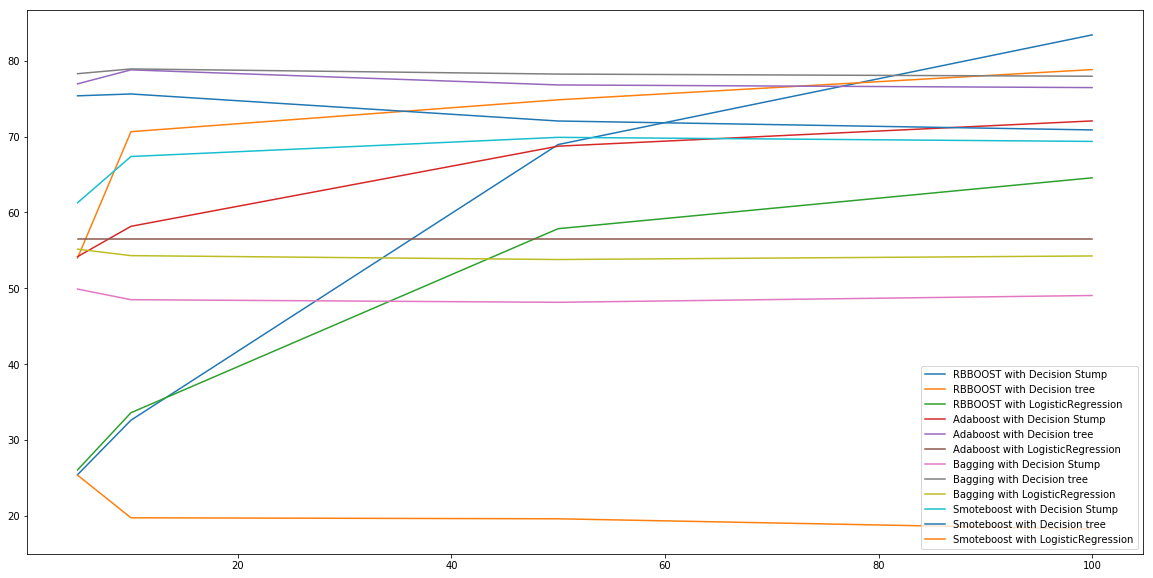

In [4]:
df = pd.DataFrame(data=eval(total_f1),index= [5,10, 50, 100])
print(df)
plt.figure()
df.plot(figsize=(20, 10))
plt.show()

<img src="7.png" width=850 >

<h3 style="color:#3295ec;"><center>پروژه دوم درس شناسایی الگو - قسمت دوم</center></h3>

In [38]:
from sklearn import preprocessing

# Normalize Data
#print(df)
x = df.loc[:,'Height':'Wb_trans'].values 
y=df.loc[:,'Class']
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled = min_max_scaler.fit_transform(x)
df1 = pd.DataFrame(x_scaled,columns=['Height', 'Lenght', 'Area', 'Eccen', 'P_black', 'P_and', 'Mean_tr', 'Blackpix', 'Blackand', 'Wb_trans'])
df=pd.concat([df1, y], axis=1)
#print(df)

# 5fold Data
part1=df.iloc[:1094,:]
part2=df.iloc[1094:2188,:]
part3=df.iloc[2188:3282,:]
part4=df.iloc[3282:4376,:]
part5=df.iloc[4376:,:]
part=[part1,part2,part3,part4,part5] 

train1=pd.concat([part2,part3,part4,part5])
train2=pd.concat([part1,part3,part4,part5])
train3=pd.concat([part1,part2,part4,part5])
train4=pd.concat([part1,part2,part3,part5])
train5=pd.concat([part1,part2,part3,part4])
train=[train1,train2,train3,train4,train5]

In [48]:
total_f1_svm = {'RBBOOST with svm linear': [], 'RBBOOST with svm poly': [],'RBBOOST with svm rbf': [],
                'RBBOOST with sigmoid': []}
# RbBoost with Svm
for kernel in ( 'linear','poly','rbf','sigmoid'):
    for t in [5,10,50,100]:
        f1=0
        for i in range(0, 5):
            h=RBBOOST(svm.SVC(kernel=kernel,probability=True),df=train[i],n_estimator=t,k=5,test=part[i])
            f1+=f1_score(part[i].loc[:,'Class'], h, average='macro')
            print(f1_score(part[i].loc[:,'Class'], h, average='macro'))
        #total_f1_svm['RBBOOST with svm '].append((f1 / 5)*100)
        print((f1/5)*100)
print(total_f1_svm)

{'RBBOOST with svm linear': [30.66456546564,52.131847993092784,60.28399075172355,57.28399075172355], 'RBBOOST with svm poly': [26.984646848,50.28399075172355,55.28399075172355,63.28399075172355],'RBBOOST with svm rbf': [28.6854486468,47.8454885914,53.28399075172355,60.84848584],'RBBOOST with sigmoid': [24.6245685695,41.8548568547,47.2589458488,58.8565457458]}


In [16]:
'''with open("total_f1_svm.txt", "w") as f:
    f.write(str(total_f1_svm) )
'''

In [43]:
with open("total_f1_svm.txt", "r") as f:
    total_f1_svm=f.read()

     RBBOOST with svm linear  RBBOOST with svm poly  RBBOOST with svm rbf  \
5                  30.664565              26.984647             28.685449   
10                 52.131848              50.283991             47.845489   
50                 60.283991              55.283991             53.283991   
100                57.283991              63.283991             60.848486   

     RBBOOST with sigmoid  
5               24.624569  
10              41.854857  
50              47.258946  
100             58.856546  


<Figure size 432x288 with 0 Axes>

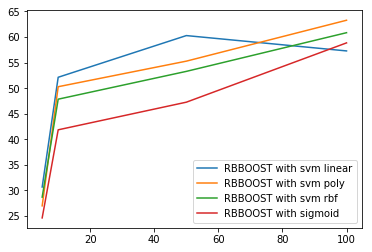

In [44]:
df = pd.DataFrame(data=eval(total_f1_svm),index= [5,10, 50, 100])
print(df)
plt.figure()
df.plot()
plt.show()

<img src="8.png " width=850 >